In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f, shapiro, boxcox
from statsmodels.stats.diagnostic import het_breuschpagan


def run_regression_analysis(X, y, purpose="prediction", transformation="none", cv_folds=5):
    """
    Function to conduct end-to-end linear regression analysis with optional response variable transformation.

    Parameters:
    - X: Predictor matrix (DataFrame or numpy array)
    - y: Continuous response variable (Series or numpy array)
    - purpose: Either 'prediction' or 'explanation'
    - transformation: Transformation for y ('none', 'log', 'sqrt', 'boxcox')
    - cv_folds: Number of folds for cross-validation

    Returns:
    - Dictionary containing model metrics, chosen model parameters, and diagnostic plots.
    """
    results = {}

    #Preprocessing
    X = X.dropna()
    y = y.loc[X.index] if hasattr(y, 'loc') else y[X.index]

    print("\nDiagnostics BEFORE Transformation:")

    # Fit an OLS model for diagnostics
    X_const = sm.add_constant(X)  # Add intercept for OLS
    ols_model_before = sm.OLS(y, X_const).fit()

    ### Diagnostics

    # Normality Check (Shapiro-Wilk Test and Q-Q Plot)
    stat_before, p_value_before = shapiro(ols_model_before.resid)
    print(f"Shapiro-Wilk Test (Before): W={stat_before:.4f}, p={p_value_before:.4f}")
    sm.qqplot(ols_model_before.resid, line='45')
    plt.title("Q-Q Plot for Residuals (Before Transformation)")
    plt.show()

    # Homoscedasticity Check (Breusch-Pagan Test)
    bp_stat_before, bp_p_value_before, _, _ = het_breuschpagan(ols_model_before.resid, ols_model_before.model.exog)
    print(f"Breusch-Pagan Test (Before): LM={bp_stat_before:.4f}, p={bp_p_value_before:.4f}")

    # Linearity Check (Residuals vs Fitted Values)
    plt.scatter(ols_model_before.fittedvalues, ols_model_before.resid, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residuals vs Fitted Values (Before Transformation)")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    ### Transformation

    # Apply Transformation to y
    print("\nApplying Transformation to y...")
    if transformation == "log":
        if (y <= 0).any():
            print("y contains non-positive values; adding a constant before log transformation.")
            y = y + abs(y.min()) + 1
        y_transformed = np.log(y)
        print("Log Transformation Applied.")
    elif transformation == "sqrt":
        if (y < 0).any():
            print("y contains negative values; adding a constant before square root transformation.")
            y = y + abs(y.min()) + 1
        y_transformed = np.sqrt(y)
        print("Square Root Transformation Applied.")
    elif transformation == "boxcox":
        if (y <= 0).any():
            print("y contains non-positive values; adding a constant before Box-Cox transformation.")
            y = y + abs(y.min()) + 1
        y_transformed, lambda_val = boxcox(y)
        print(f"Box-Cox Transformation Applied: Lambda = {lambda_val:.4f}")
    else:  # No transformation
        y_transformed = y
        print("No Transformation Applied.")

    print("\nDiagnostics AFTER Transformation:")

    # Fit OLS model after transformation
    ols_model_after = sm.OLS(y_transformed, X_const).fit()

    # Check residuals
    plt.scatter(ols_model_after.fittedvalues, ols_model_after.resid, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residuals vs Fitted Values (After Transformation)")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Normality Check (Shapiro-Wilk Test and Q-Q Plot)
    stat_after, p_value_after = shapiro(ols_model_after.resid)
    print(f"Shapiro-Wilk Test (After): W={stat_after:.4f}, p={p_value_after:.4f}")
    sm.qqplot(ols_model_after.resid, line='45')
    plt.title("Q-Q Plot for Residuals (After Transformation)")
    plt.show()

    # Homoscedasticity Check (Breusch-Pagan Test)
    bp_stat_after, bp_p_value_after, _, _ = het_breuschpagan(ols_model_after.resid, ols_model_after.model.exog)
    print(f"Breusch-Pagan Test (After): LM={bp_stat_after:.4f}, p={bp_p_value_after:.4f}")

    ##### Outliers, leverage points, and influential points

    # Cook's Distance
    influence = ols_model_after.get_influence()
    cooks_distance, _ = influence.cooks_distance
    plt.stem(range(len(cooks_distance)), cooks_distance, markerfmt="o")
    plt.xlabel("Observation Number")
    plt.ylabel("Cook's Distance")
    plt.title("Cook's Distance Plot")
    plt.show()

    # Leverage Values
    leverage = influence.hat_matrix_diag
    plt.scatter(leverage, cooks_distance)
    plt.xlabel("Leverage")
    plt.ylabel("Cook's Distance")
    plt.title("Leverage vs. Cook's Distance Plot")
    plt.show()

    ### F-test

    print("\nPerforming F-tests for Nested Models...")

    reduced_X = X_const.drop(columns=X_const.columns[-1], axis=1)  # Drop the last predictor
    reduced_model = sm.OLS(y_transformed, reduced_X).fit()

    rss_full = np.sum(ols_model_after.resid ** 2)
    rss_reduced = np.sum(reduced_model.resid ** 2)
    df_full = int(ols_model_after.df_resid)
    df_reduced = int(reduced_model.df_resid)
    df_diff = df_reduced - df_full

    f_stat = ((rss_reduced - rss_full) / df_diff) / (rss_full / df_full)
    p_value_f_test = 1 - f.cdf(f_stat, df_diff, df_full)

    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value_f_test:.4f}")

    ### Fit Ridge and Lasso

    print("\nFitting Ridge and Lasso models...")
    ridge = Ridge()
    ridge_params = {'alpha': np.logspace(-3, 3, 7)}
    ridge_cv = GridSearchCV(ridge, ridge_params, cv=cv_folds, scoring='neg_mean_squared_error')
    ridge_cv.fit(X, y_transformed)
    best_ridge = ridge_cv.best_estimator_

    lasso = Lasso(max_iter=10000)
    lasso_params = {'alpha': np.logspace(-3, 3, 7)}
    lasso_cv = GridSearchCV(lasso, lasso_params, cv=cv_folds, scoring='neg_mean_squared_error')
    lasso_cv.fit(X, y_transformed)
    best_lasso = lasso_cv.best_estimator_

    ### Explain or predict


    if purpose == "explanation":
      print("\nInterpreting OLS Coefficients...")
      ols_summary = ols_model_after.summary()
      print(ols_summary)

    else:

          models = {
              "OLS": ols_model_after,
              "Ridge": best_ridge,
              "Lasso": best_lasso
          }

          metrics = {}
          for model_name, model in models.items():
              if model_name == "OLS":
                  predictions = model.predict(X_const)
                  mse = mean_squared_error(y_transformed, predictions)
                  aic = model.aic
                  bic = model.bic
                  adjusted_r2 = 1 - (1 - model.rsquared) * (len(y_transformed) - 1) / (len(y_transformed) - X.shape[1] - 1)
              else:
                  predictions = model.predict(X)
                  mse = mean_squared_error(y_transformed, predictions)
                  rss = np.sum((y_transformed - predictions) ** 2)
                  aic = len(y_transformed) * np.log(rss / len(y_transformed)) + 2 * (X.shape[1] + 1)
                  bic = len(y_transformed) * np.log(rss / len(y_transformed)) + np.log(len(y_transformed)) * (X.shape[1] + 1)
                  adjusted_r2 = 1 - (1 - r2_score(y_transformed, predictions)) * (len(y_transformed) - 1) / (len(y_transformed) - X.shape[1] - 1)

              metrics[model_name] = {
                  "MSE": mse,
                  "AIC": aic,
                  "BIC": bic,
                  "Adjusted R^2": adjusted_r2
              }

          results["Model Metrics"] = metrics

          print("\nModel Metrics Summary:")
          for model_name, metrics in results["Model Metrics"].items():
              print(f"\n{model_name}:")
              for metric, value in metrics.items():
                  if value is not None:
                      print(f"  {metric}: {value:.4f}")

    return results

Saving Housing.csv to Housing.csv

Diagnostics BEFORE Transformation:
Shapiro-Wilk Test (Before): W=0.9540, p=0.0000


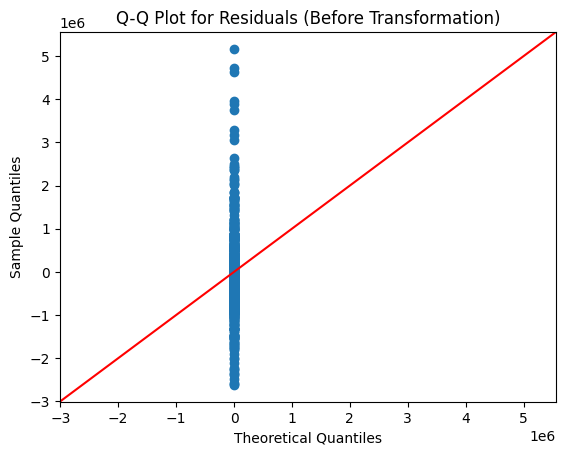

Breusch-Pagan Test (Before): LM=68.4164, p=0.0000


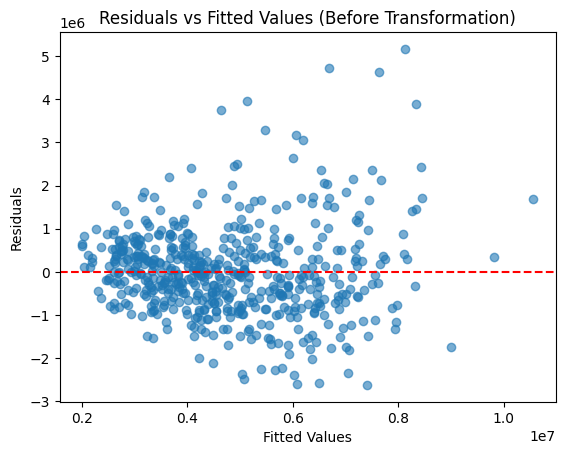


Applying Transformation to y...
Box-Cox Transformation Applied: Lambda = -0.1346

Diagnostics AFTER Transformation:


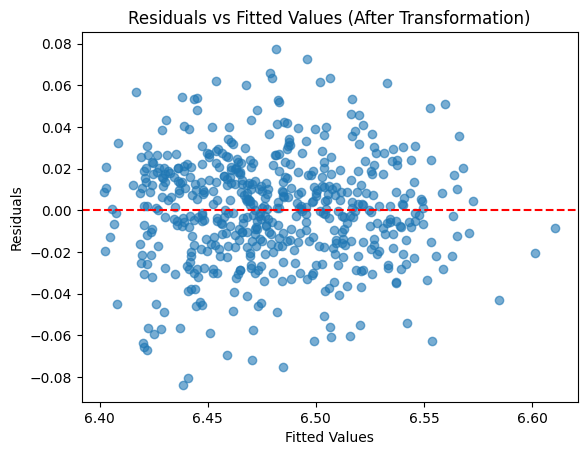

Shapiro-Wilk Test (After): W=0.9933, p=0.0164


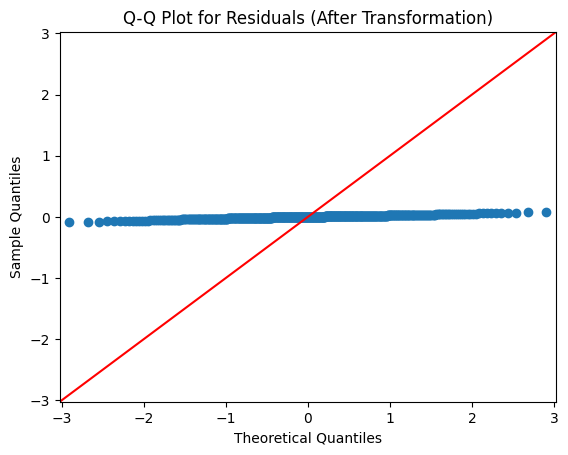

Breusch-Pagan Test (After): LM=29.1912, p=0.0061


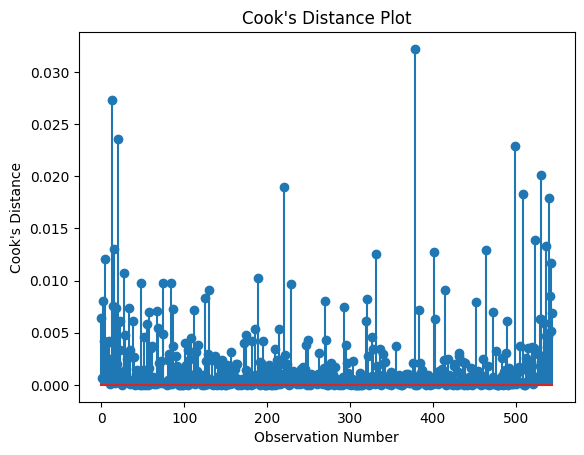

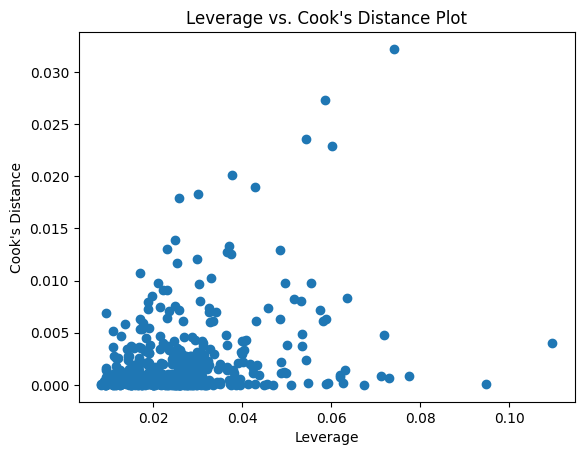


Performing F-tests for Nested Models...
F-statistic: 21.3141
P-value: 0.0000

Fitting Ridge and Lasso models...

Model Metrics Summary:

OLS:
  MSE: 0.0007
  AIC: -2398.6410
  BIC: -2338.4300
  Adjusted R^2: 0.6871

Ridge:
  MSE: 0.0007
  AIC: -3945.2840
  BIC: -3885.0730
  Adjusted R^2: 0.6871

Lasso:
  MSE: 0.0007
  AIC: -3910.0902
  BIC: -3849.8792
  Adjusted R^2: 0.6663


In [2]:
# Import necessary libraries
from google.colab import files
import pandas as pd
import numpy as np

# Upload the dataset
uploaded = files.upload()

# Load the dataset into a DataFrame
data = pd.read_csv('Housing.csv')

# Separate target (y) and predictors (X)
y = data['price']
X = data.drop(columns=['price'])

# Ensure all categorical variables are one-hot encoded
categorical_columns = ['mainroad', 'guestroom', 'basement',
                       'hotwaterheating', 'airconditioning',
                       'prefarea', 'furnishingstatus']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Convert boolean columns to integers
X = X.astype(int)

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')

# Drop rows with missing values
if X.isnull().sum().any() or y.isnull().sum() > 0:
    print("Missing values detected. Cleaning data...")
    X = X.dropna()
    y = y.loc[X.index]  # Align y with X after dropping rows

# Run the regression analysis
results = run_regression_analysis(X, y, purpose="prediction",transformation="boxcox")  # or "explanation"

Prediction Explanation

When looking at the residuals vs y^ we can see a nonconstant plot. After running different transformations we came that boxcox was the best one that was able to transform the residual plot to more constant. However when testing for normality we had a hard time transforming it to fall along the qq plot line. We were able to increase the p-value for the Shapiro Wilk test from 0 to 0.016 but still not enough to claim normality.

The f-test shows a high f-statistic with a low p-value indicating that it is better to use the full model versus a model with less predictors.

For specifically for prediction using ridge here is the best choice. The MSE is all the same for each model and we can take a look at the AIC and BIC levels. Since lower values of AIC and BIC indicates a better model in terms of balancing goodnees of fit and complexity, ridge is the better choice.


Diagnostics BEFORE Transformation:
Shapiro-Wilk Test (Before): W=0.9540, p=0.0000


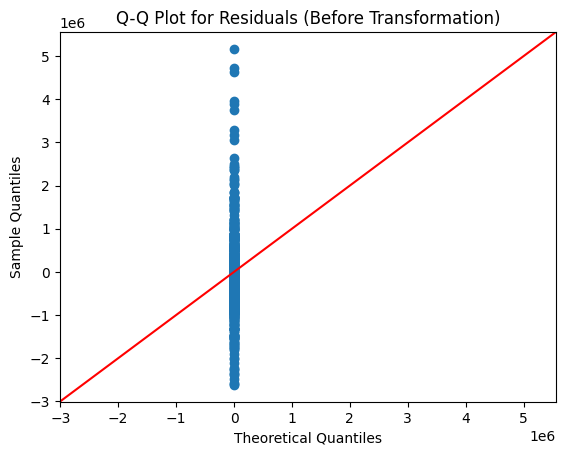

Breusch-Pagan Test (Before): LM=68.4164, p=0.0000


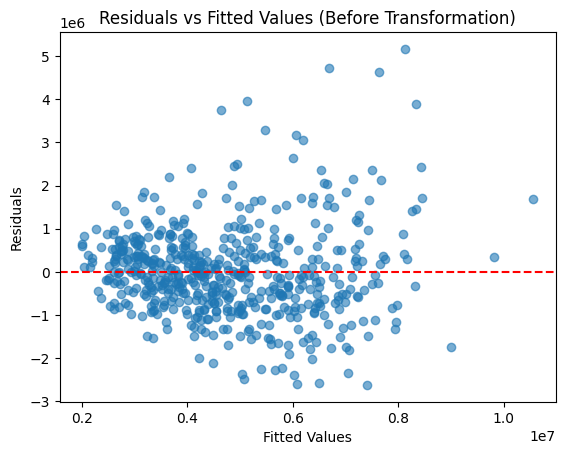


Applying Transformation to y...
Box-Cox Transformation Applied: Lambda = -0.1346

Diagnostics AFTER Transformation:


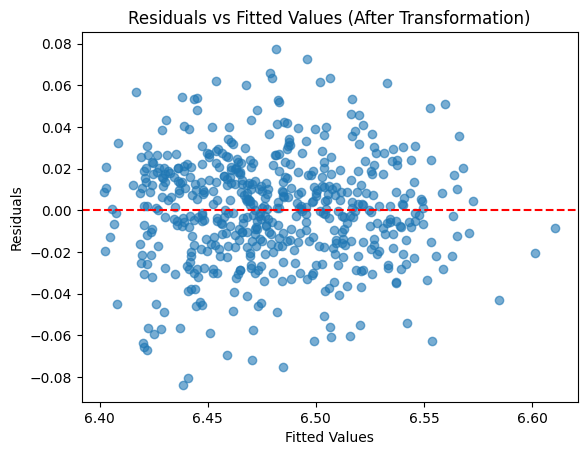

Shapiro-Wilk Test (After): W=0.9933, p=0.0164


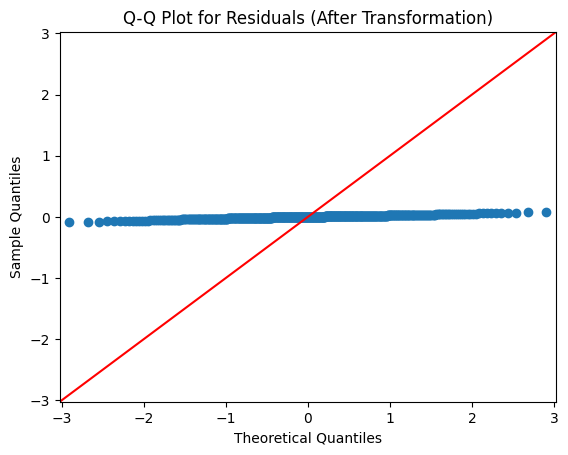

Breusch-Pagan Test (After): LM=29.1912, p=0.0061


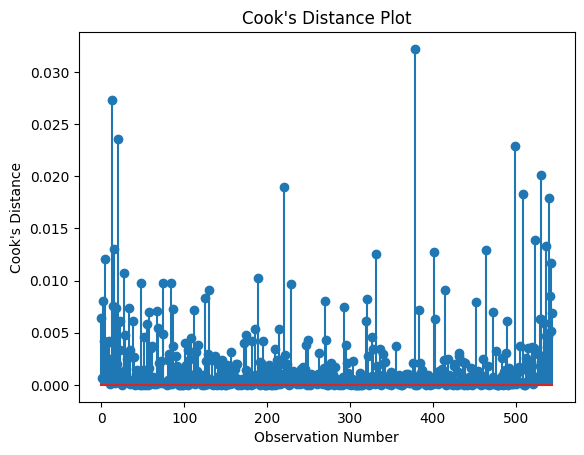

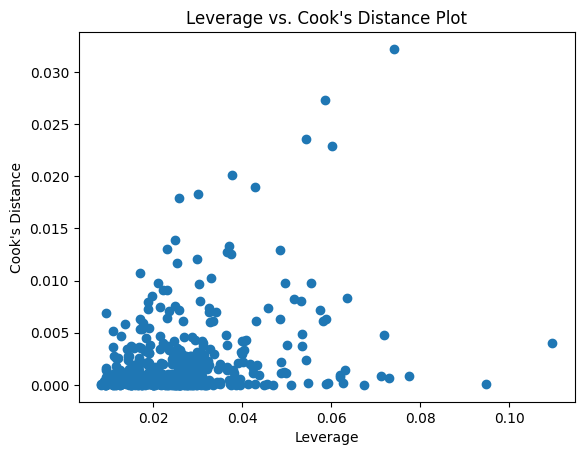


Performing F-tests for Nested Models...
F-statistic: 21.3141
P-value: 0.0000

Fitting Ridge and Lasso models...

Interpreting OLS Coefficients...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     92.91
Date:                Fri, 09 May 2025   Prob (F-statistic):          1.83e-127
Time:                        23:30:59   Log-Likelihood:                 1213.3
No. Observations:                 545   AIC:                            -2399.
Df Residuals:                     531   BIC:                            -2338.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          

In [3]:
# Run the regression analysis for explanatory
results = run_regression_analysis(X, y, purpose="explanation",transformation="boxcox")

Explanatory Explanation

The Ordinary Least Squares (OLS) regression model was used to understand the relationship between the predictors and the transformed response variable (house price). The model achieved an Adjusted 𝑅^2 of 0.687, indicating that 68.7% of the variance in house prices is explained by the predictors. This is important because we are looking at explanatory power and we are not concerned about overfitting.

Coefficients and significance of variables

area: For each one-unit increase in area, y increases by 6.266e-06

bedrooms: Each additional bedroom is associated with an increase in y by 0.0038

bathrooms: Each additional bathroom increases y by 0.0201.

stories: Each additional story increases y by 0.0114

parking: Each additional parking space increases y by 0.0055

mainroad_yes: If a house is located on the main road, y increases by 0.0154.

guestroom_yes: If a house has a guestroom, y increases by 0.0089.

basement_yes: If a house has a basement, y increases by 0.0116.

hotwaterheating_yes: If a house has hot water heating, y increases by 0.0205.

airconditioning_yes: If a house has air conditioning, y increases by 0.0221.

prefarea_yes: If a house is located in a preferred area, y increases by 0.0160.

furnishingstatus_semi-furnished: The effect of being semi-furnished is 0.0027,

furnishingstatus_unfurnished: A house being unfurnished is associated with a decrease of 0.0144 in y